# Pothole Detection

[Complex Yolo Model](##Complex-Yolo-Model)

[Model 3](##Model-3)

### Install and Import Dependencies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
import pandas as pd
import seaborn as sns
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU, Dense, Flatten, Input, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model, load_model, Sequential
import pickle
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data

This data comes from the [Cracks and Potholes in Road Images Dataset](https://github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset/tree/master/Dataset). It is licensed under the MIT License, giving us permission to modify and distribute the data for both private and commercial use.

DATA DESCRIPTION

In [ ]:
import platform
mysystem = platform.system()
# We need to first download the data here:
file_download_link = "https://github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset/zipball/master"
# Check for windows

if mysystem != 'Windows':
    !wget -O dataset.zip --no-check-certificate "$file_download_link"
    !unzip dataset.zip

print('Please download the data using the following link:', file_download_link)

--2022-11-20 08:02:09--  https://github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset/zipball/master
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset/legacy.zip/refs/heads/master [following]
--2022-11-20 08:02:10--  https://codeload.github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset/legacy.zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘dataset.zip’

dataset.zip             [                <=> ] 224.54M  19.0MB/s    in 13s     

2022-11-20 08:02:25 (16.8 MB/s) - ‘dataset.zip’ saved [235450096]

Archive:  dataset.zip
1f200

### Create Dataset

The first step is to create the dataset with the images, their labels, and the parameters for the pothole bounding boxes. We will use **keras** to load and convert images to numpy arrays, and **cv2** to detect the potholes and label them. We store the dataset as a csv file.

Below is an example of how cv2 creates a bounding box around a pothole using the provided masks.

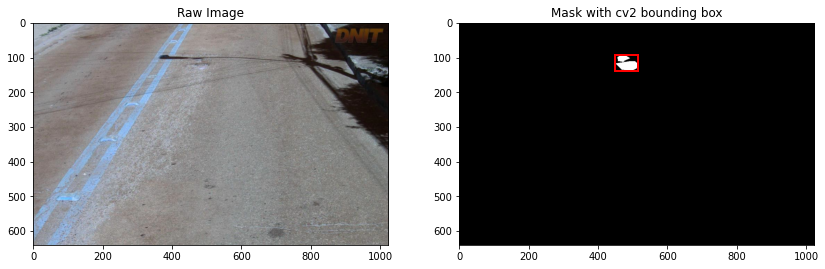

In [ ]:
master = 'drive/MyDrive/biankatpas Cracks-and-Potholes-in-Road-Images-Dataset master Dataset'
path = master + "/820315_ES_259_259ES000000_03060/820315_ES_259_259ES000000_03060_RAW.jpg"
raw_img = cv2.imread(path)
path = master + "/820315_ES_259_259ES000000_03060/820315_ES_259_259ES000000_03060_POTHOLE.png"
mask = cv2.imread(path, 0)
x,y,w,h = cv2.boundingRect(mask)
fig, axs = plt.subplots(1,2, figsize=(14,20))
axs[0].set_title("Raw Image")
axs[0].imshow(raw_img)
axs[1].set_title("Mask with cv2 bounding box")
axs[1].imshow(mask, cmap= 'gray')
axs[1].add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))

In [ ]:
# Create Train/Validation csv
imgs = []
img_paths = []
width = []
height = []
pothole = []
x_center = []
y_center = []
box_w = []
box_h = []
box_w_h = []
xmin = []
xmax = []
ymin = []
ymax = []
box_min_max = []

master = 'biankatpas Cracks-and-Potholes-in-Road-Images-Dataset master Dataset'
samples = os.listdir(master)
for sample in samples:
    # Path for Raw Image
    img_path = master + "/" + sample + "/" + sample + "_RAW.jpg"
    img_paths.append(img_path)
    # Load image into ram
    # We resize it to (600, 600) and convert to grayscale
    img = keras.preprocessing.image.load_img(img_path, color_mode = 'grayscale', target_size = (600, 600))
    img = keras.preprocessing.image.img_to_array(img)
    img = img/255
    imgs.append(img)
    
    # Image Dimensions
    width.append(600)
    height.append(600)
    
    # Get bounding box of image
    path = master + "/" + sample + "/" + sample + "_POTHOLE.png"
    mask = cv2.imread(path, 0)
    # Convert from 0-255 to 0-1
    mask = (mask > 0).astype(np.uint8)
    mask = cv2.resize(mask,[600,600],cv2.INTER_NEAREST)
    x,y,w,h = cv2.boundingRect(mask)
    x_center.append(x)
    y_center.append(y)
    box_w.append(w)
    box_h.append(h)
    box_w_h.append((x,y,w,h))
    xmin.append(x - int((w/2)))
    ymin.append(y - int((h/2)))
    xmax.append(x + int((w/2)))
    ymax.append(y + int((h/2)))
    box_min_max.append([x - int((w/2)), y - int((h/2)), x + int((w/2)), y + int((h/2))])
    
    # Get label
    if ((x == 0) and (y == 0) and (w == 0) and (h == 0)):
        label = 0
    else:
        label = 1
    pothole.append(label)

# Create Df and csv
df = pd.DataFrame({'img':imgs, 'img_path':img_paths , 'width':width, 'height':height, 'x_center':x_center, 'y_center':y_center, 'box_w':box_w, 'box_h':box_h, 'box_w_h':box_w_h, 'xmin':xmin, 'xmax':xmax, 'ymin':ymin, 'ymax':ymax, 'box_min_max':box_min_max, 'pothole':pothole})
df.to_csv('pothole_data.csv', index=None)

In [8]:
# Load data from csv
potholes = pd.read_csv('drive/MyDrive/pothole_data.csv')
potholes.head()

,img,img_path,width,height,x_center,y_center,box_w,box_h,box_w_h,xmin,xmax,ymin,ymax,box_min_max,pothole
0,[[[0.25882354]\n [0.24705882]\n [0.23529412]...,biankatpas Cracks-and-Potholes-in-Road-Images-...,600,600,0,0,0,0,"(0, 0, 0, 0)",0,0,0,0,"[0, 0, 0, 0]",0
1,[[[0.26666668]\n [0.26666668]\n [0.25882354]...,biankatpas Cracks-and-Potholes-in-Road-Images-...,600,600,0,0,0,0,"(0, 0, 0, 0)",0,0,0,0,"[0, 0, 0, 0]",0
2,[[[0.38039216]\n [0.36862746]\n [0.43137255]...,biankatpas Cracks-and-Potholes-in-Road-Images-...,600,600,0,0,0,0,"(0, 0, 0, 0)",0,0,0,0,"[0, 0, 0, 0]",0
3,[[[0.49803922]\n [0.35686275]\n [0.36862746]...,biankatpas Cracks-and-Potholes-in-Road-Images-...,600,600,0,0,0,0,"(0, 0, 0, 0)",0,0,0,0,"[0, 0, 0, 0]",0
4,[[[0.2784314 ]\n [0.23921569]\n [0.07450981]...,biankatpas Cracks-and-Potholes-in-Road-Images-...,600,600,161,375,52,25,"(161, 375, 52, 25)",135,187,363,387,"[135, 363, 187, 387]",1


### Data Exploration

We are working with a dataset that contains $2235$ samples (images). The target classes are $0$ and $1$, which correspond to the given road containing a pothole ($1$) or not ($0$)

In [ ]:
# Number of Observations
len(potholes)

2235

In [ ]:
# Number of Classes
np.unique(potholes['pothole'])

array([0, 1], dtype=int64)

#### Class distribution

As we can see in the target class distribution, the data is a bit imbalanced. We have $564$ samples with potholes, and $1671$ samples without. This prior could lead to problems, and we will need to adjust how we train our model accordingly.


Images with potholes: 564
Images without potholes: 1671


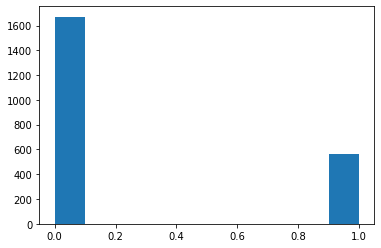

In [ ]:
# Class distribution
plt.hist(potholes['pothole'])
print("Images with potholes: " + str(len(potholes[potholes['pothole']>0])))
print("Images without potholes: " + str(len(potholes[potholes['pothole']<1])))

#### Distribution of bounding box widths and heights

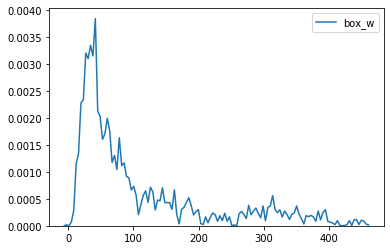

In [ ]:
# Distribution of bounding box widths
sns.kdeplot(potholes['box_w'])

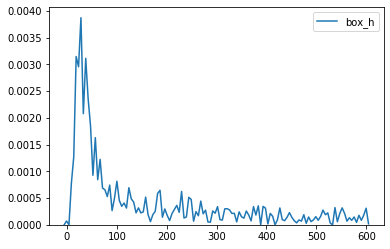

In [ ]:
# Distribution of bouding box heights
sns.kdeplot(potholes['box_h'])

#### Examples of each target class

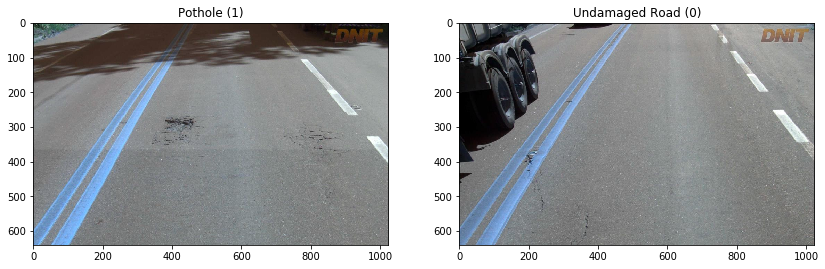

In [ ]:
# Plot Examples of Classes
master = 'biankatpas Cracks-and-Potholes-in-Road-Images-Dataset master Dataset'
path = master + "/765254_ES_259_259ES000000_00370/765254_ES_259_259ES000000_00370_RAW.jpg"
pothole_example = cv2.imread(path)
path = master + "/765442_ES_259_259ES000000_01310/765442_ES_259_259ES000000_01310_RAW.jpg"
undamaged_example = cv2.imread(path)
fig, axs = plt.subplots(1,2, figsize=(14,20))
axs[0].set_title("Pothole (1)")
axs[0].imshow(pothole_example)
axs[1].set_title("Undamaged Road (0)")
axs[1].imshow(undamaged_example)

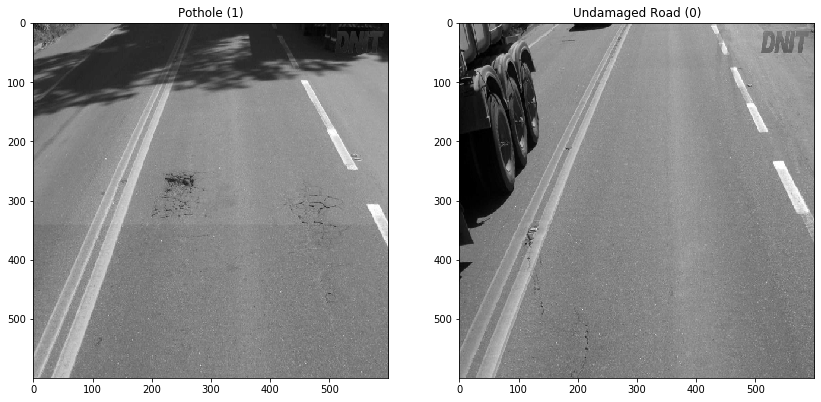

In [ ]:
# After rescaling and normalization
master = 'biankatpas Cracks-and-Potholes-in-Road-Images-Dataset master Dataset'
path = master + "/765254_ES_259_259ES000000_00370/765254_ES_259_259ES000000_00370_RAW.jpg"
img = keras.preprocessing.image.load_img(path, color_mode = 'grayscale', target_size = (600, 600))
img = np.asarray(img)
pothole_example = img/255
path = master + "/765442_ES_259_259ES000000_01310/765442_ES_259_259ES000000_01310_RAW.jpg"
img = keras.preprocessing.image.load_img(path, color_mode = 'grayscale', target_size = (600, 600))
img = np.asarray(img)
undamaged_example = img/255
fig, axs = plt.subplots(1,2, figsize=(14,20))
axs[0].set_title("Pothole (1)")
axs[0].imshow(pothole_example, cmap= 'gray')
axs[1].set_title("Undamaged Road (0)")
axs[1].imshow(undamaged_example, cmap= 'gray')

### Train/Validate split

In [ ]:
# Train/Valitate split
imgs_greyscale = []
imgs_color = []

for path in potholes['img_path']:
    p = "drive/MyDrive/" + path
    img_grey = keras.preprocessing.image.load_img(p, color_mode = 'grayscale', target_size = (600, 600))
    img_grey = keras.preprocessing.image.img_to_array(img_grey)
    img_grey = img_grey/255
    img_color = keras.preprocessing.image.load_img(p, target_size = (600, 600))
    img_color = keras.preprocessing.image.img_to_array(img_color)
    img_color = img_color/255
    imgs_greyscale.append(img_grey)
    imgs_color.append(img_color)
X_grey = np.array(imgs_greyscale)
X_color = np.array(imgs_color)
y = np.array(potholes[["xmin", "ymin", "xmax", "ymax", "pothole"]].values.tolist())


In [ ]:
X_grey_file = open('drive/MyDrive/X_grey.obj', 'wb')
pickle.dump(X_grey, X_grey_file)
X_grey_file.close()
X_color_file = open('drive/MyDrive/X_color.obj', 'wb')
pickle.dump(X_color, X_color_file)
X_color_file.close()
y_file = open('drive/MyDrive/y.obj', 'wb')
pickle.dump(y, y_file)
y_file.close()

In [3]:
X_grey_obj = open('drive/MyDrive/X_grey.obj', 'rb')
X_grey = pickle.load(X_grey_obj)
X_grey_obj.close()

In [21]:
X_color_obj = open('drive/MyDrive/X_color.obj', 'rb')
X_color = pickle.load(X_color_obj)
X_color_obj.close()

In [4]:
y_obj = open('drive/MyDrive/y.obj', 'rb') 
y = pickle.load(y_obj)
y_obj.close()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
y_train = np.delete(y_train, 4, 1)
y_test2 = np.delete(y_test, 4, 1)
y_val2 = np.delete(y_val, 4, 1)

## Branched VGG16 Model

In [2]:
labels = np.array(pd.read_csv('drive/MyDrive/pothole_data.csv')['pothole'])[:700]

In [3]:
X_color_obj = open('drive/MyDrive/X_color.obj', 'rb')
X_color = pickle.load(X_color_obj)[:700]
X_color_obj.close()

In [4]:
y_obj = open('drive/MyDrive/y.obj', 'rb') 
y = pickle.load(y_obj)[:700]
y_obj.close()
y = np.delete(y, 4, 1)
# Scale
y = y/600

In [5]:
split = train_test_split(X_color, labels, y, test_size=0.20, random_state=42)
(X_train, X_test) = split[:2]
(label_train, label_test) = split[2:4]
(y_train, y_test) = split[4:6]

In [6]:
def calculate_iou(target, pred):
    target = tf.cast(target, tf.float32)
    xA = K.maximum(target[:,0], pred[:,0])
    yA = K.maximum(target[:,1], pred[:,1])
    xB = K.minimum(target[:,2], pred[:,2])
    yB = K.minimum(target[:,3], pred[:,3])
    interArea = K.maximum(0.0, xB-xA)*K.maximum(0.0,yB-yA)
    boxAarea = (target[:,2]-target[:,0])*(target[:,3]-target[:,1])
    boxBarea = (pred[:,2]-pred[:,0]) * (pred[:,3]-pred[:,1])
    iou = interArea / (boxAarea+boxBarea - interArea)
    return iou

def iou_metric(y_true, y_pred):
    return calculate_iou(y_true, y_pred)

In [10]:
# Load the initial VGG16 wieghts, with the head layers left off
vgg = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(600, 600, 3)))
# Freeze VGG layers so they won't be updated during training
vgg.trainable = False
# Flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# Dense layer header to output the predicted box coordinates
bboxHead = Dense(1240, activation="relu")(flatten)
bboxHead = Dense(620, activation="relu")(bboxHead)
bboxHead = Dense(310, activation="relu")(bboxHead)
bboxHead = Dense(155, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)
# Dense layer header to output the class label
classHead = Dense(512, activation="relu")(flatten)
classHead = Dropout(0.5)(classHead)
classHead = Dense(512, activation="relu")(classHead)
classHead = Dropout(0.5)(classHead)
classHead = Dense(1, activation="softmax", name="class_label")(classHead)

# Construct the model
branched_model = Model(inputs=vgg.input, outputs=(bboxHead, classHead))
# Different losses
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# Equal weight for class and bounding box prediction
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}

branched_model.compile(loss=losses, optimizer=Adam(lr=0.0001), metrics=["accuracy"], loss_weights=lossWeights)

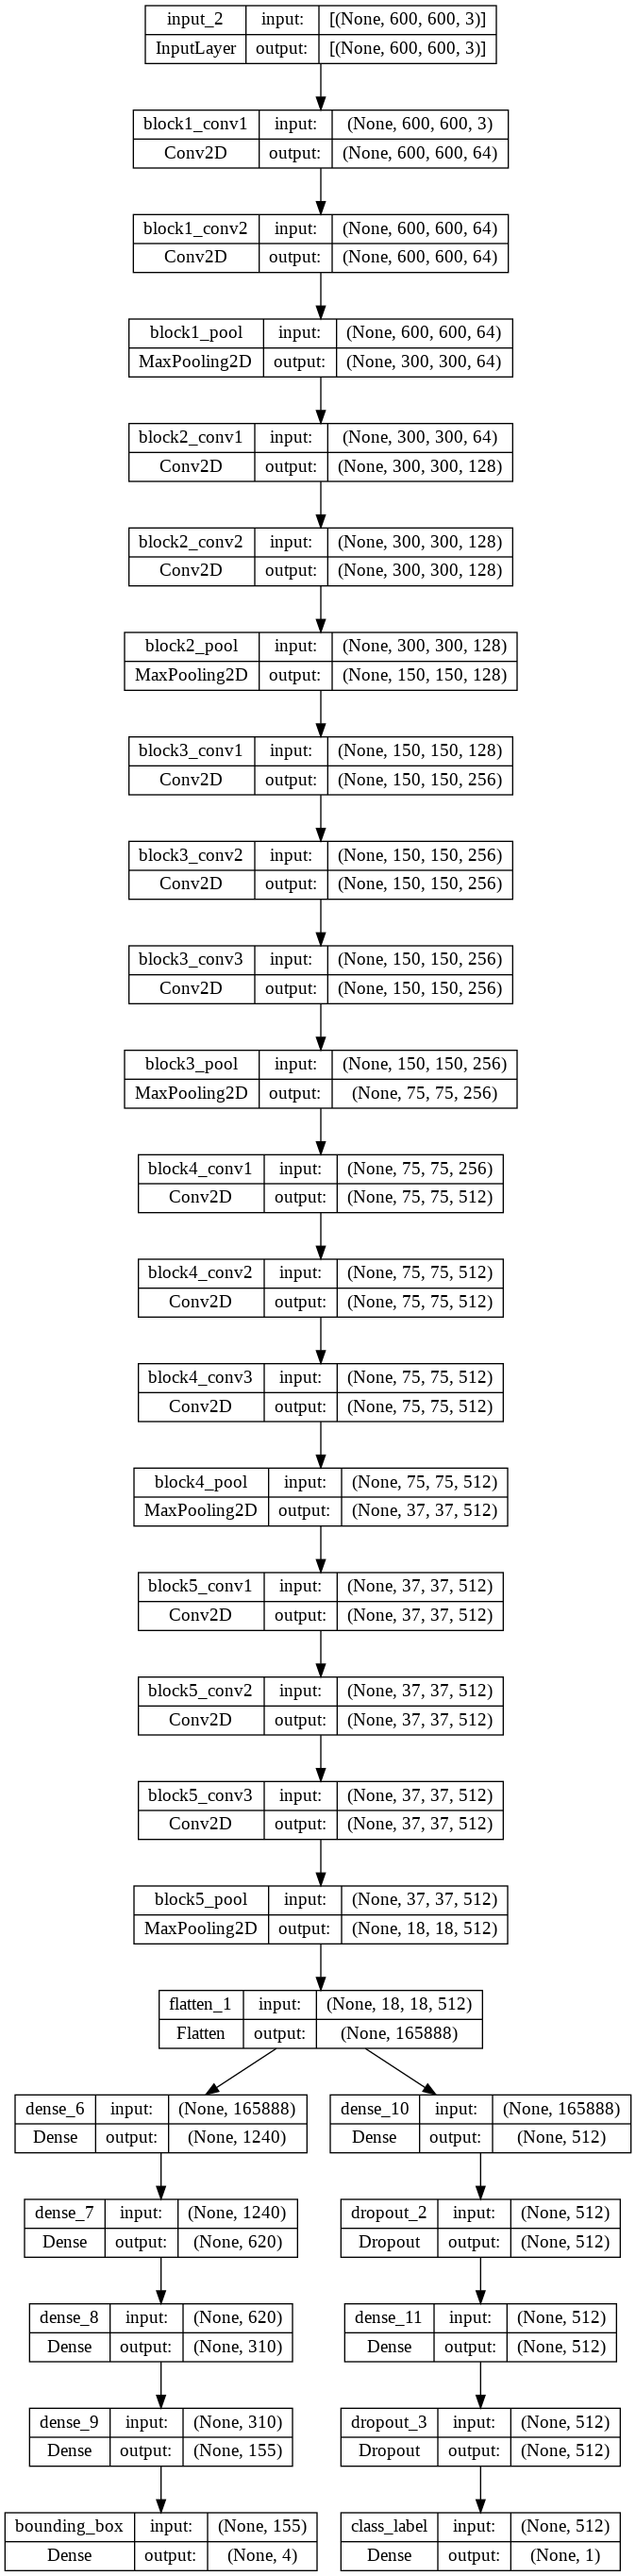

In [12]:
tf.keras.utils.plot_model(
    branched_model,
    to_file="branched_model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [8]:
trainTargets = {
	"class_label": label_train,
	"bounding_box": y_train
}

testTargets = {
	"class_label": label_test,
	"bounding_box": y_test
}

In [11]:
branched_model_history = branched_model.fit(
	X_train, trainTargets,
	validation_data=(X_test, testTargets),
	batch_size=2,
	epochs=15,
	verbose=1)

Epoch 1/15
280/280 [==============================] - 59s 172ms/step - loss: 0.0925 - bounding_box_loss: 0.0925 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.1946 - class_label_accuracy: 0.3196 - val_loss: 0.0944 - val_bounding_box_loss: 0.0944 - val_class_label_loss: 0.0000e+00 - val_bounding_box_accuracy: 0.1500 - val_class_label_accuracy: 0.3214
Epoch 2/15
280/280 [==============================] - 48s 173ms/step - loss: 0.0915 - bounding_box_loss: 0.0915 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.1446 - class_label_accuracy: 0.3196 - val_loss: 0.0944 - val_bounding_box_loss: 0.0944 - val_class_label_loss: 0.0000e+00 - val_bounding_box_accuracy: 0.1500 - val_class_label_accuracy: 0.3214
Epoch 3/15
280/280 [==============================] - 49s 175ms/step - loss: 0.0918 - bounding_box_loss: 0.0918 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.4714 - class_label_accuracy: 0.3196 - val_loss: 0.0944 - val_bounding_box_loss: 0.0944 - val_class_label

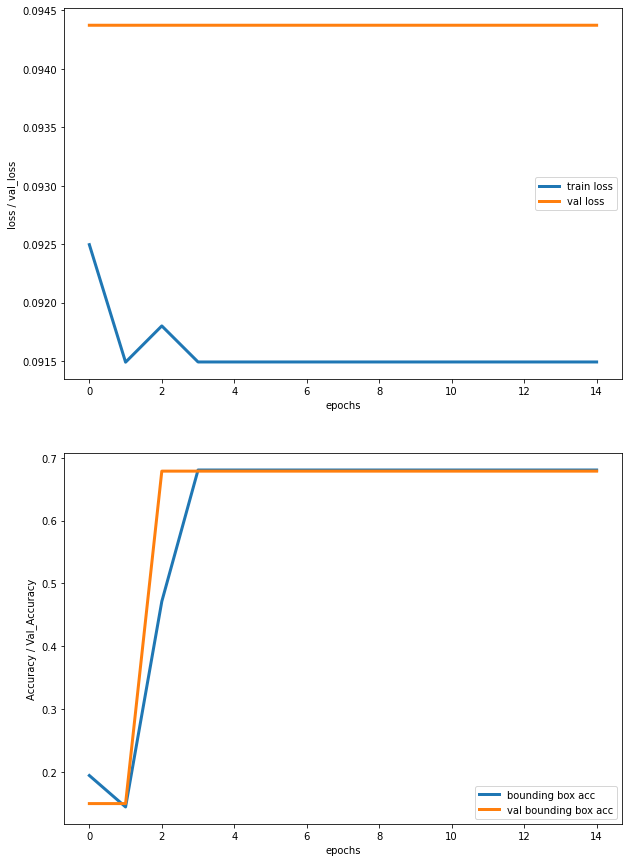

In [14]:
loss = branched_model_history.history['loss']
val_loss = branched_model_history.history['val_loss']

bb_acc = branched_model_history.history['bounding_box_accuracy']
val_bb_acc = branched_model_history.history['val_bounding_box_accuracy']

class_acc = branched_model_history.history['class_label_accuracy']
val_class_acc = branched_model_history.history['val_class_label_accuracy']


plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.plot(loss , linewidth=3 ,label='train loss')
plt.plot(val_loss , linewidth=3, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss / val_loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(bb_acc , linewidth=3 ,label='bounding box acc')
plt.plot(val_bb_acc , linewidth=3, label='val bounding box acc')
plt.xlabel('epochs')
plt.ylabel('Accuracy / Val_Accuracy')
plt.legend()

1/1 [==============================] - 0s 24ms/step
(array([[7.30351787e-14, 3.82390906e-17, 1.48578395e-30, 4.03491881e-28]],
      dtype=float32), array([[1.]], dtype=float32))


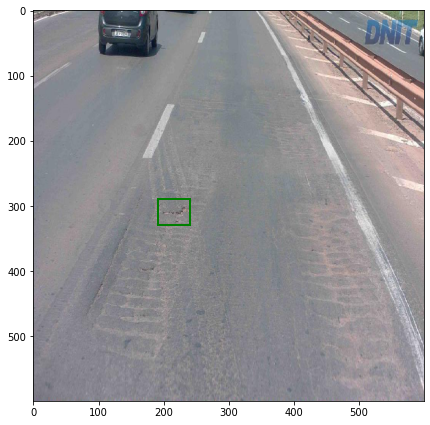

In [37]:
# Example prediction with branched model
n = 17
fig, ax = plt.subplots(1,1, figsize=(7,10))
ax.imshow(X_test[n], vmin=0, vmax=1)
xmin,ymin,xmax,ymax = (y_test[n][0]*600, y_test[n][1]*600, y_test[n][2]*600, y_test[n][3]*600)
w = (xmax-xmin)
h = (ymax-ymin)
x = round(xmin + (w/2))
y_ = round(ymin + (h/2))
ax.add_patch(patches.Rectangle((x,y_),w,h, fill=False, edgecolor='green', lw=2))
img = tf.cast(np.expand_dims(X_test[n], axis=0), tf.float32)
pred = branched_model.predict(img)
print(pred)
xmin,ymin,xmax,ymax = (pred[0][0][0]*600, pred[0][0][1]*600, pred[0][0][2]*600, pred[0][0][3]*600)
w = (xmax-xmin)
h = (ymax-ymin)
x = round(xmin + (w/2))
y_ = round(ymin + (h/2))
ax.add_patch(patches.Rectangle((x,y_),w,h, fill=False, edgecolor='red', lw=2))